In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import mysql
from mysql.connector import connect, Error
import re
import re
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import apriori
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:

cnx = mysql.connector.connect(user=f'{user}', password=f'{password}',
                              host=f'{host}', database=f"{database}")

cursor = cnx.cursor()

In [5]:
query = """
SELECT 
EDS.TWEET_ID,
EDS.EMOTION,
S.KEYWORD,
E.EVENT_NAME
FROM VW_EMOTION_DISTINCT_SETS EDS
JOIN TWEET_DATA TD ON EDS.TWEET_ID = TD.TWEET_ID
JOIN SEARCHES S ON S.SEARCH_ID = TD.SEARCH_ID
JOIN EVENTS E ON E.EVENT_ID = S.EVENT_ID
"""

emotions_all = pd.read_sql(query, cnx)

In [6]:
events = list(emotions_all.EVENT_NAME.unique())
wlex = pd.read_csv('../csv_files/emotion_lexicon_word_level.csv')
emotions = list(wlex.emotion.unique())
neg_emotions = ['anger', 'disgust', 'fear', 'sadness', 'negative']
pos_emotions = ['anticipation', 'joy', 'surprise', 'trust', 'positive']

In [82]:
def emotion_frequent_itemsets(df, min_support=0.005, k=3): #setting up the apriori calculation
    df_in = enter_the_matrix(df)
    emotion_matrix_itemset = apriori(df_in, min_support=min_support, use_colnames=True)
    out = emotion_matrix_itemset[emotion_matrix_itemset['itemsets'].apply(lambda x: len(x)) == k]
    return out

def enter_the_matrix(df):
    emotions_copy = df
    for e in emotions:
        emotions_copy[e] = emotions_all.EMOTION.str.count(e)
        emotions_copy.replace(2,1)
    emotions_copy.set_index('TWEET_ID', inplace=True)
    emotion_matrix = emotions_copy[emotions]
    return emotion_matrix

def make_my_chart(event, min_supp, knum, xlim_adjust, savefile=0):

    df = emotions_all[emotions_all['EVENT_NAME']==event]
    tweet_all_frequent_3itemsets = emotion_frequent_itemsets(df, min_support=min_supp, k=knum)
    tweet_all_frequent_3itemsets['itemsets'] = tweet_all_frequent_3itemsets['itemsets'].apply(lambda x: ', '.join(list(x))).astype("unicode")

    max = tweet_all_frequent_3itemsets['support'].max()
    med = tweet_all_frequent_3itemsets['support'].median()

    tweet_all_frequent_3itemsets['sentiment'] = None
    for ind, row in tweet_all_frequent_3itemsets.iterrows():
        pos_count = 0
        neg_count = 0
        for emo in row['itemsets'].split(', '):
            for nsent in neg_emotions:
                if emo == nsent: 
                    neg_count+=1
            for psent in pos_emotions:
                if emo ==psent: 
                    pos_count+=1
        if pos_count > neg_count: tweet_all_frequent_3itemsets.at[ind, 'sentiment'] = 'positive'
        else: tweet_all_frequent_3itemsets.at[ind,'sentiment'] = 'negative'

    fig_dims = (12, 12)
    sns.set_style(style='white')
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(rc={"lines.linewidth": 1})
    sns.barplot(data = tweet_all_frequent_3itemsets.sort_values('support'), x='support', y='itemsets', palette=["#00ACC3" if x=='positive' else '#ED4A00' for x in tweet_all_frequent_3itemsets.sort_values('support').sentiment], ax=ax)

    ax.set_xlim(med-xlim_adjust, max+0.01)
    ax.set_title(f"{event}",fontweight="bold", size=20)

    string = """
    █ = Negative Sentiment

    """ 

    props = dict(boxstyle='round', facecolor='white', alpha=0.5,zorder=5)
    ax.text(.75, .95, string, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, zorder=5, color='#ED4A00')
    ax.text(.772, .89, '█ = Positive Sentiment', transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, zorder=5, color='#00ACC3')
    
    if savefile==1:
        fig.savefig(f'../images/frequent_itemsets/fis_text_{event}.png', dpi=750, bbox_inches='tight')

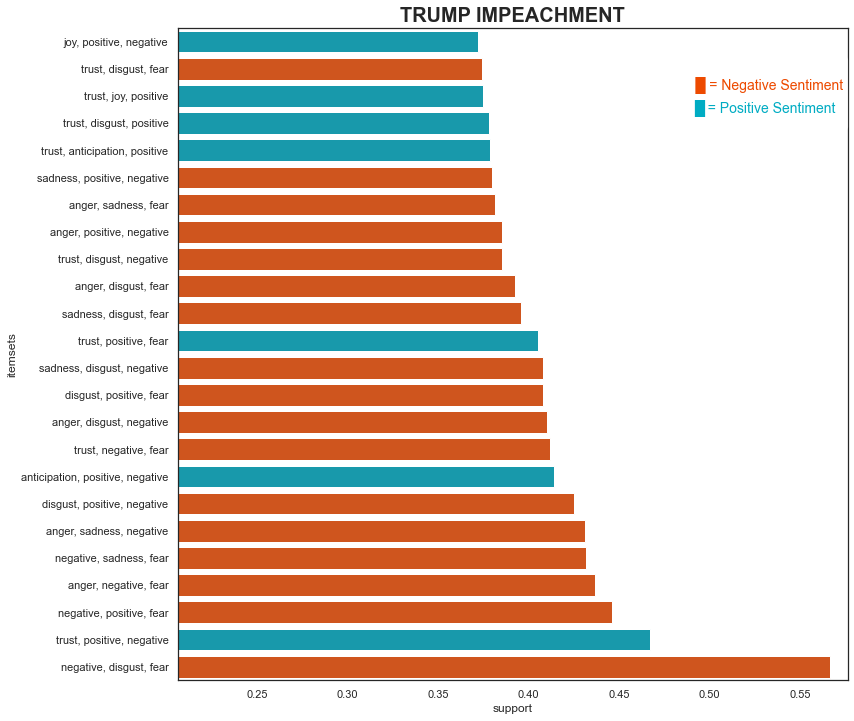

In [73]:
make_my_chart('TRUMP IMPEACHMENT', 0.37, 3, 0.2, 1)

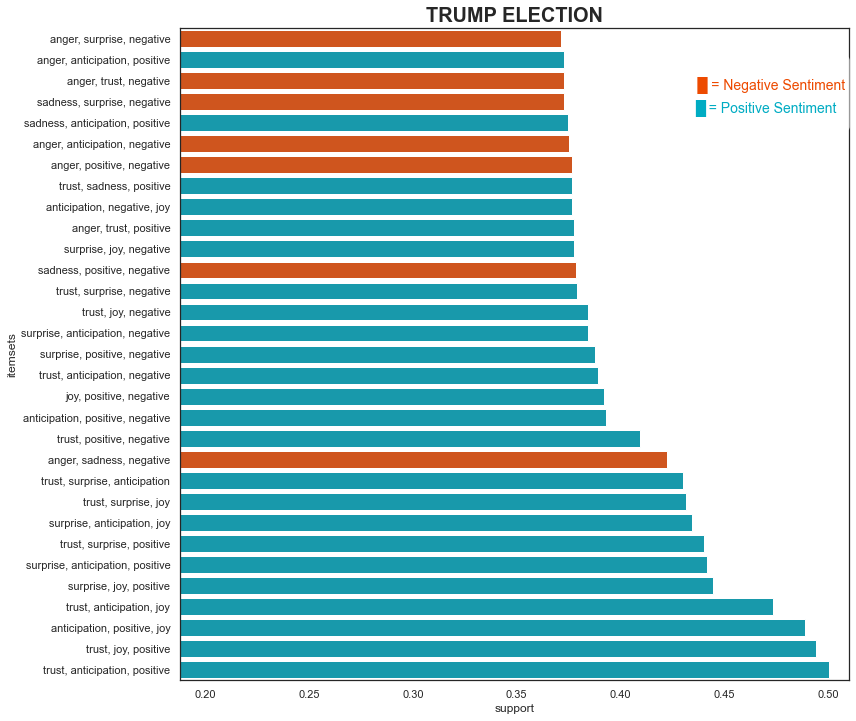

In [75]:
make_my_chart('TRUMP ELECTION', 0.37, 3, 0.2, 1)

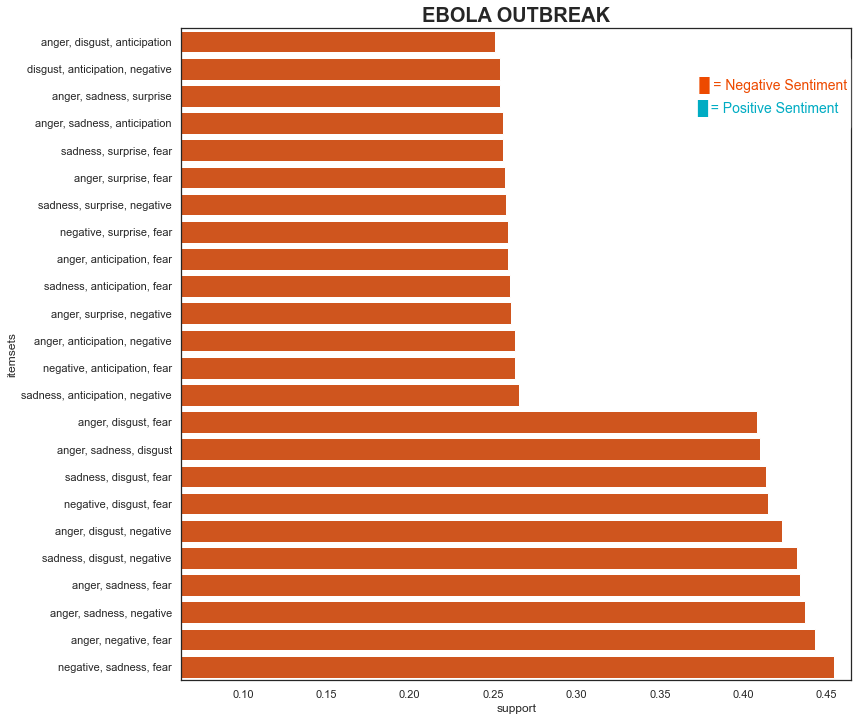

In [76]:
make_my_chart('EBOLA OUTBREAK', 0.25, 3, 0.2, 1)

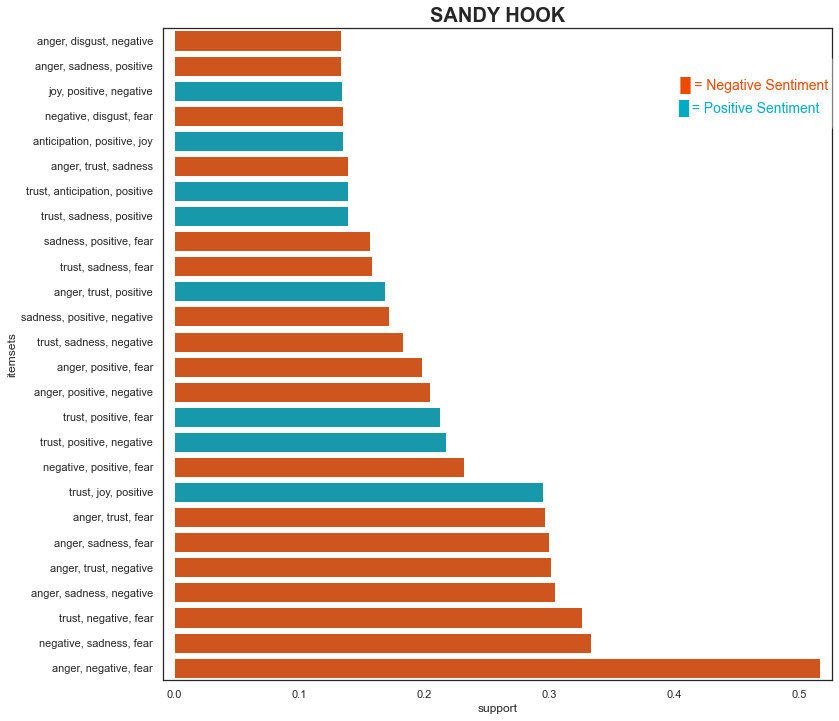

In [77]:
make_my_chart('SANDY HOOK', 0.13, 3, 0.2, 1)

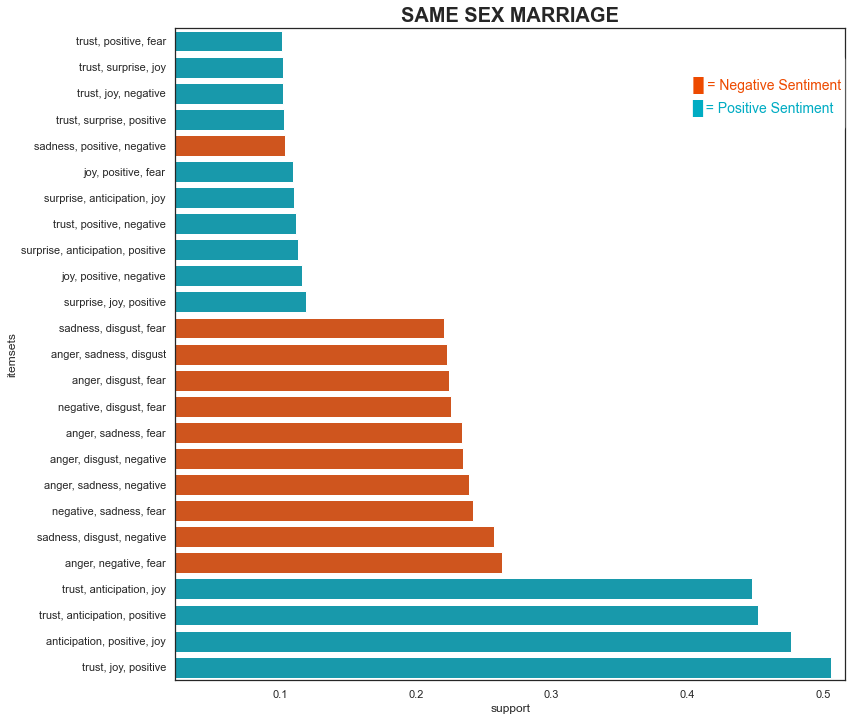

In [83]:
make_my_chart('SAME SEX MARRIAGE', 0.10, 3, 0.2, 1)